#  Прогнозирование заказов такси

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Условие:
* Значение метрики RMSE на тестовой выборке должно быть не больше 48.

План работы:

* Загрузить данные и выполнить их ресемплирование по одному часу.
* Проанализировать данные.
* Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
* Проверить данные на тестовой выборке и сделать выводы.

Данные лежат в файле taxi.csv. Количество заказов находится в столбце num_orders (от англ. number of orders, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import re
import datetime
import seaborn

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

import lightgbm as lgb

from catboost import Pool, CatBoostRegressor

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder

import warnings
warnings.filterwarnings('ignore')

In [2]:
random_magic = 1024

In [3]:
try:
    data = pd.read_csv('taxi.csv', parse_dates=['datetime'])
except:
    data = pd.read_csv('datasets/taxi.csv', parse_dates=['datetime'])

In [4]:
data

datetime  num_orders
0     2018-03-01 00:00:00           9
1     2018-03-01 00:10:00          14
2     2018-03-01 00:20:00          28
3     2018-03-01 00:30:00          20
4     2018-03-01 00:40:00          32
...                   ...         ...
26491 2018-08-31 23:10:00          32
26492 2018-08-31 23:20:00          24
26493 2018-08-31 23:30:00          27
26494 2018-08-31 23:40:00          39
26495 2018-08-31 23:50:00          53

[26496 rows x 2 columns]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Исходные данные представлены в виде одной таблицы с двумя признаками:

* datetime - дата и время
* num_orders - количество заказов

В таблице содержится порядка 26.5 тысяч записей с данными о количестве заказов такси (в 10-минутном интервале). По условиям задачи моделирования требуется спрогнозировать количество заказов такси на следующий час. Соответственно целесообразно провести ресемплирование данных по одному часу.

Укажем в качестве индекса таблицы  признак времени.

In [6]:
data = data.set_index('datetime')
data.head(5)

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32

Отсортируем данные по индексу и проверим их на хронологичность. 

In [7]:
data.sort_index(inplace=True)
data.index.is_monotonic

True

In [8]:
data

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
...                         ...
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53

[26496 rows x 1 columns]

В таблице представлены данные за период с 01 марта 2018 года по 31 августа 2018 года (6 месяцев).

Поскольку задача предсказания на час вперед выполняем ресемплирование по часу.

In [9]:
data = data.resample('1H').sum()
data

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
...                         ...
2018-08-31 19:00:00         136
2018-08-31 20:00:00         154
2018-08-31 21:00:00         159
2018-08-31 22:00:00         223
2018-08-31 23:00:00         205

[4416 rows x 1 columns]

#### Выводы:

Исходные данные представлены в виде одной таблицы с двумя признаками:

* дата и время
* количество заказов

В таблице содержится порядка 26.5 тысяч записей с данными о количестве заказов такси (в 10-минутном интервале). Данные представлены за период с 01 марта 2018 года по 31 августа 2018 года (6 месяцев)

## Анализ

 Создадим копию для анализа данных.

In [10]:
data_copy = data.copy()

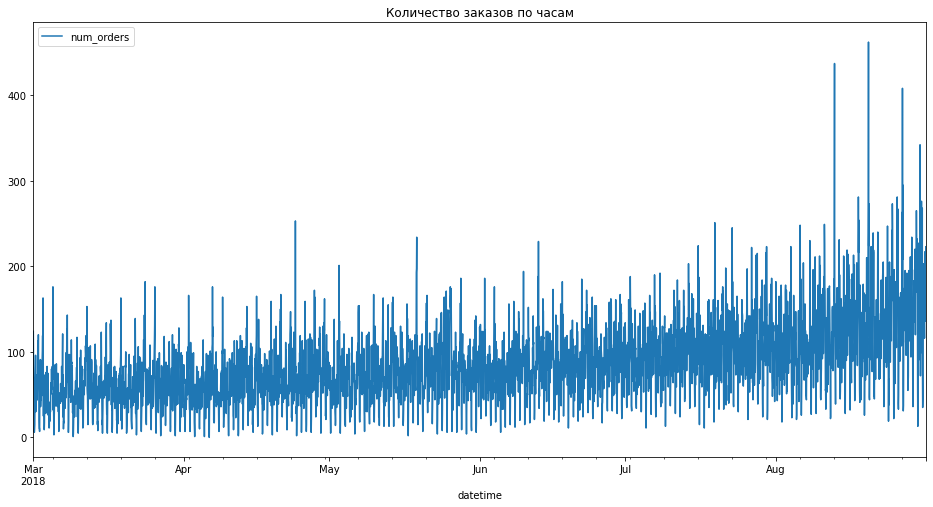

In [11]:
data_copy.plot(title='Количество заказов по часам', figsize=(16, 8));

По графику заметно, что к концу лета количество заказов в час увеличилось, возможно, потому что ученики и студенты, а так же семьи с детьми массово возвращаются к началу учебного года.



Оценим наличие трендов и сезонности средствами библиотеки statsmodels.

In [12]:
decomposed_1H = seasonal_decompose(data_copy['num_orders'])

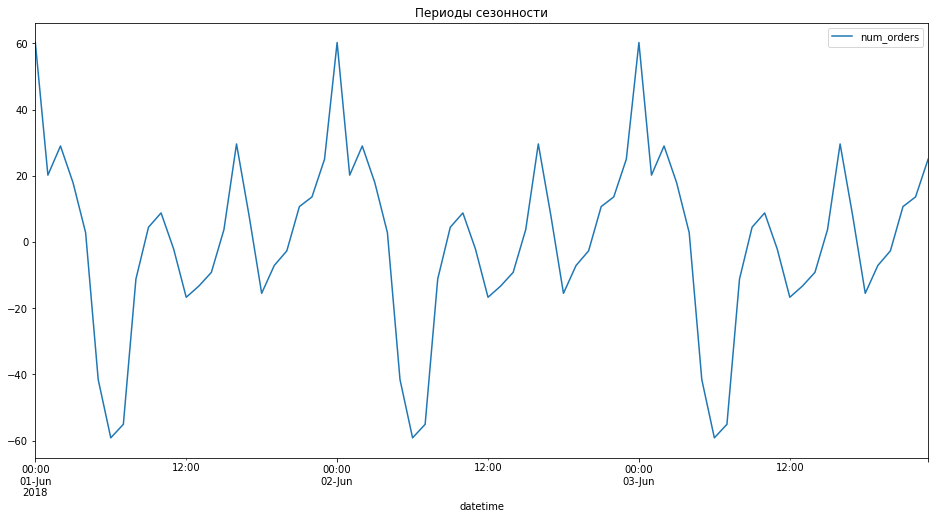

In [13]:
pd.DataFrame(decomposed_1H.seasonal['2018-06-01':'2018-06-03']).rename(columns
={"seasonal": "num_orders"}).plot(title='Периоды сезонности',figsize=(16, 8));

Часовые сезонные циклы достаточно хорошо выделены:

* сутки начинаются с пикового значения объема заказов в 0 часов
* далее следует резкое падение до минимума в районе 6 часов утра
* рост объема заказов с 7 часов и боковой тренд в рабочие часы (с 8 до 18)
* плавный рост до пикового значения с 18 до 0 часов

Целесообразно рассмотреть следующие возможные признаки для модели:

* часовой объем заказов с лагом в 24 часа
* часовой объем заказов 1, 2 и 3 часа назад
* скользящая средняя по 12 и 4 часам - со сдвигом в 1 час (для исключения утечек данных)

Указанные признаки будут добавлены к исходному датасету непосредственно перед обучением модели.

Проведем более подробный анализ . Выполним дополнительное ресемплирование данных - по дням и 4-часовым промежуткам - и выявление трендов и сезонности в полученных данных.

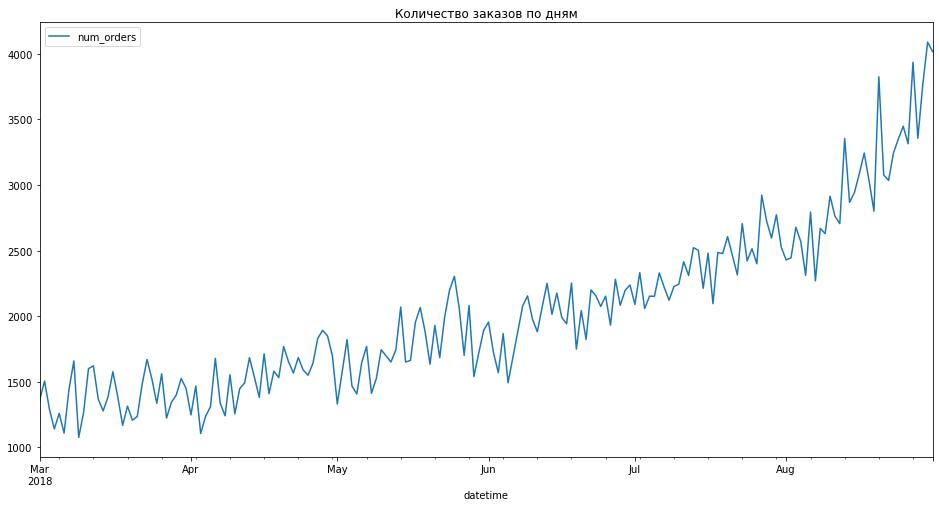

In [14]:
data_daily = data_copy.resample('1D').sum()
data_daily.plot(title='Количество заказов по дням', figsize=(16, 8));

Если рассмотреть дневные данные, то видно, что с апреля начался скромный рост заказов, а с июля этот рост начал ускоряться.

In [15]:
decomposed_1D = seasonal_decompose(data_daily['num_orders'])

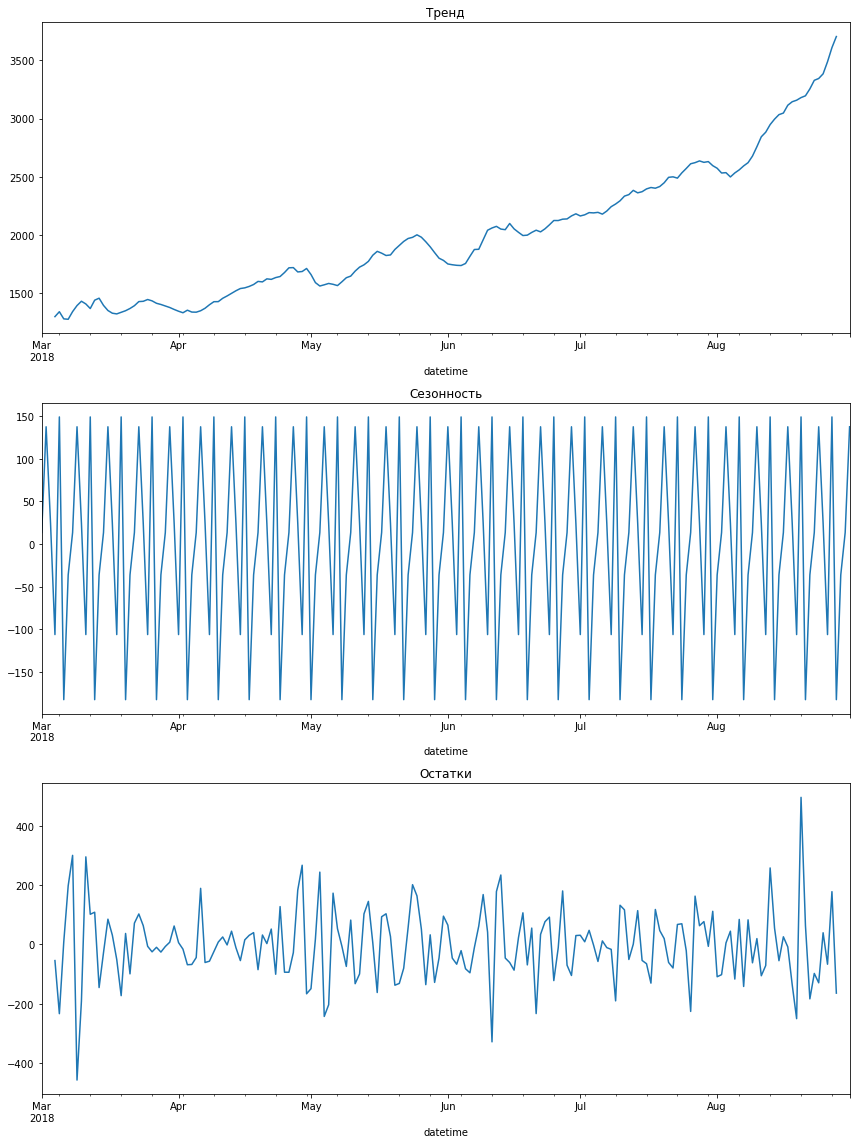

In [16]:
plt.figure(figsize=(12, 16))
plt.subplot(311)

decomposed_1D.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed_1D.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed_1D.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

На дневных графиках можно четко выделить растущий тренд, а также недельные периоды сезонности. Рассмотрим несколько таких периодов подробнее.

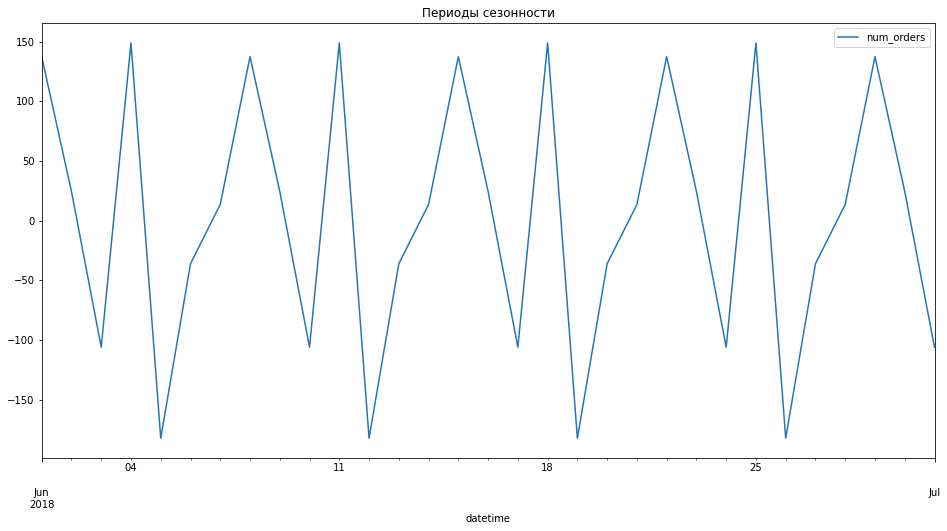

In [17]:
pd.DataFrame(decomposed_1D.seasonal['2018-06-01':'2018-07-01']).rename(columns
={"seasonal": "num_orders"}).plot(title='Периоды сезонности',figsize=(16, 8));


На графике видно ярко выраженные сезонные периоды продолжительностью 7 дней с минимальными значениями в воскресенье и вторник и пиками в понедельник и пятницу.

Выявленные закономерности позволяют сделать предположений о возможных значимых признаках для модели:

* дневной объем заказов с лагом в 7 дней (неделю назад)
* дневной объем заказов в предыдущий день
* скользящая средняя по кратным неделям периодам (например 1 и 4 недели) - со сдвигом в 1 день (для исключения утечек данных)

Указанные признаки будут добавлены к исходному датасету непосредственно перед обучением модели.

Также рассмотрим 4-часовые графики

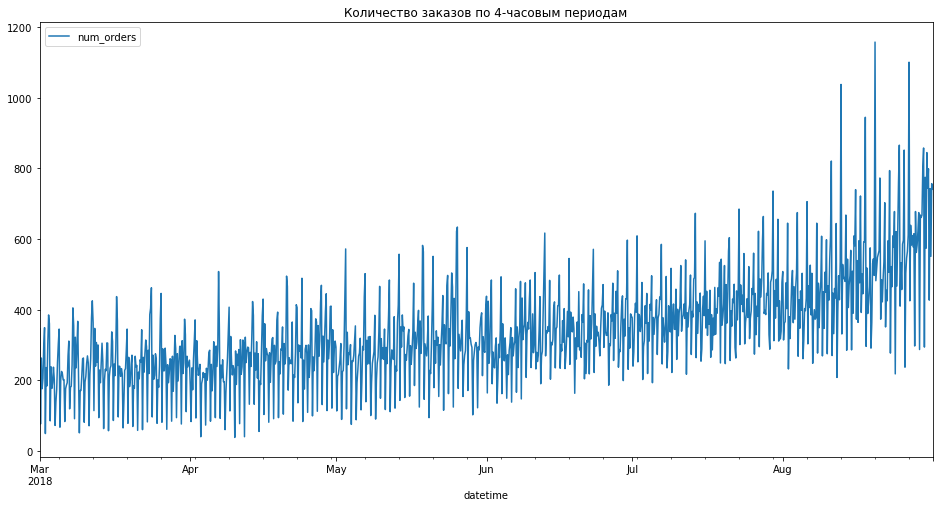

In [18]:
data_4H = data_copy.resample('4H').sum()
data_4H.plot(title='Количество заказов по 4-часовым периодам', figsize=(16, 8));

In [19]:
decomposed_4H = seasonal_decompose(data_4H['num_orders'])

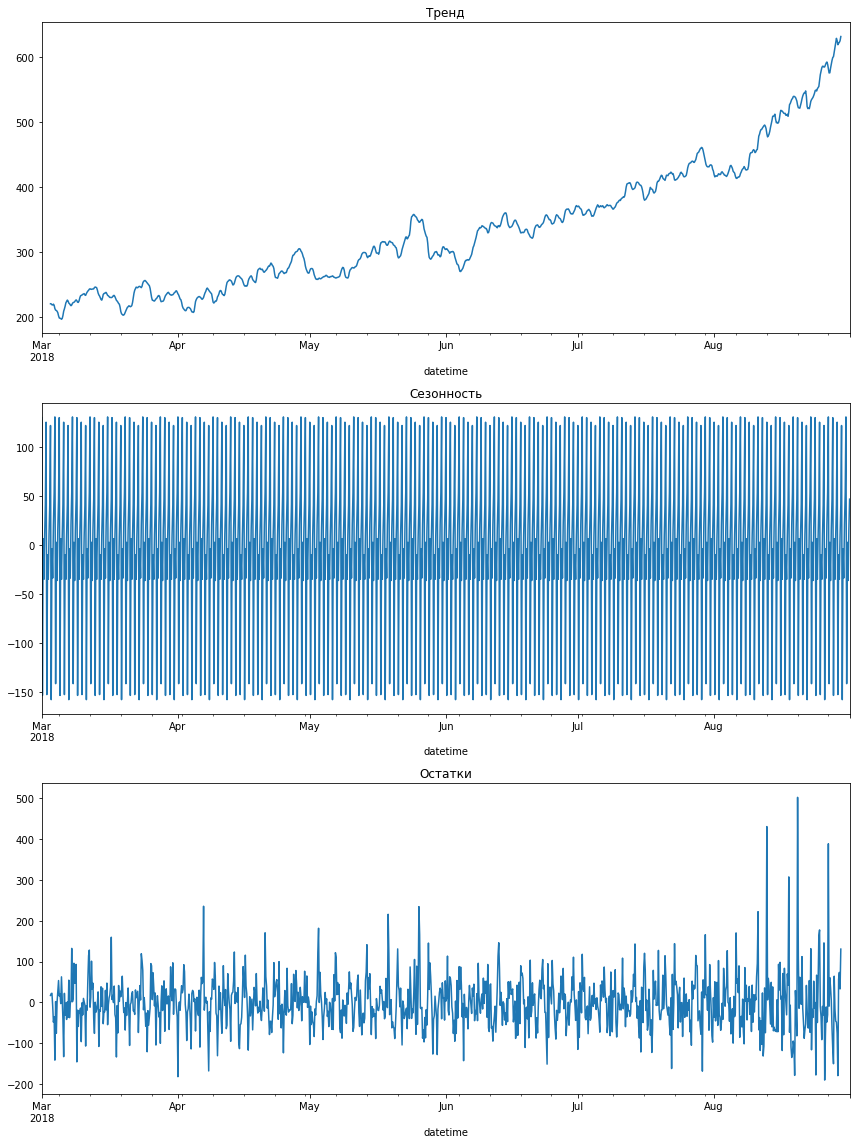

In [20]:
plt.figure(figsize=(12, 16))
plt.subplot(311)

decomposed_4H.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed_4H.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed_4H.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

Очевидным образом 4-часовые графики имеют ярко выраженную суточную сезонность.

Целесообразно рассмотреть следующие возможные признаки для модели:

* 4-часовой объем заказов с лагом в 6 периодов (сутки назад)
* 4-часовой объем заказов в предыдущий период
* скользящая средняя по кратным дням периоду (например 4 дня - 24 периода) - со сдвигом в 1 период - 4 часа (для исключения утечек данных)
* Указанные признаки будут добавлены к исходному датасету непосредственно перед обучением модели.

### Выводы:

Результаты семплирования и анализа дневных, 4-часовых и часовых графиков позволяют выявить следующие закономерности:

* общий тренд рассматриваемых данных - восходящий
* данные обладают выраженной недельной и суточной сезонностью (поскольку данные представлены только за 6 месяцев говорить о выявлении более крупных сезонных зависимостях не представляется возможным)

Эти закономерности позволяют сделать предположение о возможных обучающих признаках - различных комбинациях исторических значений (предыдущих периодов со сдвигом) и скользящих средних переменных размеров окна. При этом необходимо соблюдать требование по сдвигу значений скользящих средних для избежания утечек данных на тестовой выборке.

Переходим к проектированию обучающих признаков.

## Обучение

Снова рассмотрим весь исходный набор данных, ресемплированный по часам.

In [21]:
data.head(5)

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43

Сформируем ресемплированные по дням и 4-часовым отрезкам наборы данных.

In [22]:
data_daily = data.resample('1D').sum()
data_4H = data.resample('4H').sum()

Создадим признаки - компоненты даты - которые будут в последующем использоваться для объединения часовых данных с данными по дням и 4-часовым интервалам.

In [23]:
def make_date_features(df):
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['hour'] = df.index.hour

In [24]:
make_date_features(data)
make_date_features(data_daily)
make_date_features(data_4H)

Сгенерируем признаки для каждого из рассматриваемого периода (часовой, 4-часовой, дневной), руководствуясь следующими принципами:

* в каждом масштабе сохраняем ближайшие предыдущие значения и значения прошлого аналогичного периода (например, для недельного цикла это будут значения - 1, 2 дня назад и 7 дней назад (предыдущий аналог)
* скользящие средние комбинируем по окнам разной ширины (при этом для более коротких скользящих средних выбираем способ построения, учитывающий последния значения с бОльшим весом относительно более старых)

Сформируем признаки на основе часовых данных.

In [25]:
for lag in (1, 2, 3, 24, 48, 72):
    data['1H_lag_{}'.format(lag)] = data['num_orders'].shift(lag)

In [26]:
data['1H_rolling_mean_6'] = data['num_orders'].shift(1).rolling(6).mean()
data['1H_rolling_mean_12'] = data['num_orders'].shift(1).rolling(12).mean()

Сформируем признаки на основе данных по дням (для удобства восприятия усредним их к значению за 1 час)

In [27]:
for lag in (1, 2, 7):
    data_daily['daily_lag_{}'.format(lag)] = data_daily['num_orders'].shift(lag) / 24

In [28]:
data_daily['daily_rolling_mean_3'] = data_daily['num_orders'].shift(1).rolling(3, win_type='hann').mean() / 24
data_daily['daily_rolling_mean_7'] = data_daily['num_orders'].shift(1).rolling(7).mean() / 24
data_daily['daily_rolling_mean_14'] = data_daily['num_orders'].shift(1).rolling(14).mean() / 24

Сформируем признаки на основе 4-часовых данным.

In [29]:
for lag in (1, 2, 3, 6):
    data_4H['4H_lag_{}'.format(lag)] = data_4H['num_orders'].shift(lag) / 4

In [30]:
data_4H['4H_rolling_mean_3'] = data_4H['num_orders'].shift(1).rolling(3, win_type='hann').mean() / 4
data_4H['4H_rolling_mean_6'] = data_4H['num_orders'].shift(1).rolling(6, win_type='hann').mean() / 4
data_4H['4H_rolling_mean_24'] = data_4H['num_orders'].shift(1).rolling(24).mean() / 4

In [31]:
data_4H.head(5)

num_orders  dayofweek  month  day  hour  4H_lag_1  \
datetime                                                                 
2018-03-01 00:00:00         346          3      3    1     0       NaN   
2018-03-01 04:00:00          76          3      3    1     4     86.50   
2018-03-01 08:00:00         263          3      3    1     8     19.00   
2018-03-01 12:00:00         176          3      3    1    12     65.75   
2018-03-01 16:00:00         205          3      3    1    16     44.00   

                     4H_lag_2  4H_lag_3  4H_lag_6  4H_rolling_mean_3  \
datetime                                                               
2018-03-01 00:00:00       NaN       NaN       NaN                NaN   
2018-03-01 04:00:00       NaN       NaN       NaN                NaN   
2018-03-01 08:00:00     86.50       NaN       NaN                NaN   
2018-03-01 12:00:00     19.00      86.5       NaN              19.00   
2018-03-01 16:00:00     65.75      19.0       NaN              65.75   

                     4H_rolling_mean_6  4H_rolling_mean_24  
datetime                                                    
2018-03-01 00:00:00                NaN                 NaN  
2018-03-01 04:00:00                NaN                 NaN  
2018-03-01 08:00:00                NaN                 NaN  
2018-03-01 12:00:00                NaN                 NaN  
2018-03-01 16:00:00                NaN                 NaN

Для последующего объединения с часовыми данными "размножим" строчки набора данных, заполнив все интервальные значения часов (т.е. например строчка со значением часов = 0 дублируется 4 раза, значения часов заполняются в интервале от 0 до 3 с шагом 1)

In [32]:
data_4H = data_4H.loc[data_4H.index.repeat(4)]
data_4H['hour'] += data_4H.groupby(level=0).cumcount()

In [33]:
data_4H.head(10)

num_orders  dayofweek  month  day  hour  4H_lag_1  \
datetime                                                                 
2018-03-01 00:00:00         346          3      3    1     0       NaN   
2018-03-01 00:00:00         346          3      3    1     1       NaN   
2018-03-01 00:00:00         346          3      3    1     2       NaN   
2018-03-01 00:00:00         346          3      3    1     3       NaN   
2018-03-01 04:00:00          76          3      3    1     4      86.5   
2018-03-01 04:00:00          76          3      3    1     5      86.5   
2018-03-01 04:00:00          76          3      3    1     6      86.5   
2018-03-01 04:00:00          76          3      3    1     7      86.5   
2018-03-01 08:00:00         263          3      3    1     8      19.0   
2018-03-01 08:00:00         263          3      3    1     9      19.0   

                     4H_lag_2  4H_lag_3  4H_lag_6  4H_rolling_mean_3  \
datetime                                                               
2018-03-01 00:00:00       NaN       NaN       NaN                NaN   
2018-03-01 00:00:00       NaN       NaN       NaN                NaN   
2018-03-01 00:00:00       NaN       NaN       NaN                NaN   
2018-03-01 00:00:00       NaN       NaN       NaN                NaN   
2018-03-01 04:00:00       NaN       NaN       NaN                NaN   
2018-03-01 04:00:00       NaN       NaN       NaN                NaN   
2018-03-01 04:00:00       NaN       NaN       NaN                NaN   
2018-03-01 04:00:00       NaN       NaN       NaN                NaN   
2018-03-01 08:00:00      86.5       NaN       NaN                NaN   
2018-03-01 08:00:00      86.5       NaN       NaN                NaN   

                     4H_rolling_mean_6  4H_rolling_mean_24  
datetime                                                    
2018-03-01 00:00:00                NaN                 NaN  
2018-03-01 00:00:00                NaN                 NaN  
2018-03-01 00:00:00                NaN                 NaN  
2018-03-01 00:00:00                NaN                 NaN  
2018-03-01 04:00:00                NaN                 NaN  
2018-03-01 04:00:00                NaN                 NaN  
2018-03-01 04:00:00                NaN                 NaN  
2018-03-01 04:00:00                NaN                 NaN  
2018-03-01 08:00:00                NaN                 NaN  
2018-03-01 08:00:00                NaN                 NaN

Объединим в одной таблице исходные часовые данные и подготовленную статистику по более крупным периодам - неделям и 4-часовым интервалам.

In [34]:
data_merged = data.reset_index().merge(
    data_daily, on=['month', 'day'], how='inner'
)

In [35]:
data_merged.drop([col for col in data_merged.columns if "_y" in col], axis=1, inplace=True)
data_merged = data_merged.rename(columns=lambda x: x.replace('_x', ''))

In [36]:
data_merged = data_merged.merge(
    data_4H, on=['month', 'day', 'hour'], how='inner'
)

In [37]:
data_merged.drop([col for col in data_merged.columns if "_y" in col], axis=1, inplace=True)
data_merged = data_merged.rename(columns=lambda x: x.replace('_x', ''))

In [38]:
data_merged = data_merged.dropna()
data_merged.set_index('datetime', inplace=True)

# удаление признаков месяца и дня

data_merged.drop(columns=['month', 'day'], inplace=True)
data_merged.head(5)

num_orders  dayofweek  hour  1H_lag_1  1H_lag_2  \
datetime                                                               
2018-03-15 00:00:00         123          3     0      65.0      81.0   
2018-03-15 01:00:00          85          3     1     123.0      65.0   
2018-03-15 02:00:00          55          3     2      85.0     123.0   
2018-03-15 03:00:00          42          3     3      55.0      85.0   
2018-03-15 04:00:00          15          3     4      42.0      55.0   

                     1H_lag_3  1H_lag_24  1H_lag_48  1H_lag_72  \
datetime                                                         
2018-03-15 00:00:00      77.0       84.0       91.0      102.0   
2018-03-15 01:00:00      81.0       72.0       88.0      153.0   
2018-03-15 02:00:00      65.0       39.0       58.0       57.0   
2018-03-15 03:00:00     123.0       57.0       63.0       51.0   
2018-03-15 04:00:00      85.0       21.0       42.0       49.0   

                     1H_rolling_mean_6  ...  daily_rolling_mean_3  \
datetime                                ...                         
2018-03-15 00:00:00          69.500000  ...             57.041667   
2018-03-15 01:00:00          79.166667  ...             57.041667   
2018-03-15 02:00:00          85.666667  ...             57.041667   
2018-03-15 03:00:00          81.000000  ...             57.041667   
2018-03-15 04:00:00          75.166667  ...             57.041667   

                     daily_rolling_mean_7  daily_rolling_mean_14  4H_lag_1  \
datetime                                                                     
2018-03-15 00:00:00             58.755952              56.491071     76.50   
2018-03-15 01:00:00             58.755952              56.491071     76.50   
2018-03-15 02:00:00             58.755952              56.491071     76.50   
2018-03-15 03:00:00             58.755952              56.491071     76.50   
2018-03-15 04:00:00             58.755952              56.491071     76.25   

                     4H_lag_2  4H_lag_3  4H_lag_6  4H_rolling_mean_3  \
datetime                                                               
2018-03-15 00:00:00     56.75     57.75     63.00              56.75   
2018-03-15 01:00:00     56.75     57.75     63.00              56.75   
2018-03-15 02:00:00     56.75     57.75     63.00              56.75   
2018-03-15 03:00:00     56.75     57.75     63.00              56.75   
2018-03-15 04:00:00     76.50     56.75     15.75              76.50   

                     4H_rolling_mean_6  4H_rolling_mean_24  
datetime                                                    
2018-03-15 00:00:00          48.913119           61.135417  
2018-03-15 01:00:00          48.913119           61.135417  
2018-03-15 02:00:00          48.913119           61.135417  
2018-03-15 03:00:00          48.913119           61.135417  
2018-03-15 04:00:00          58.873810           61.718750  

[5 rows x 24 columns]

В итоговом датасете собраны и приведены к единой масштабной шкале данные как по часовым интервалам (предыдущие значения, скользящие средние), так и данные более крупных интервалов (4-часовые, дневные).

Переходим непосредственно к обучению моделей.

Разделим датасет на обучающую и тестовую выборки в соответствии с исходными требованиями - объем теста 10%. Разделение будем производить без перемешивания (тестовые данные - в конце рассматриваемого периода)

In [39]:
df_train, df_test = train_test_split(data_merged, shuffle=False, test_size=0.1)

Определим обучающие и целевой признаки. Также выделим категориальные признаки - день недели и час.

In [40]:
target = ['num_orders']

features = [col for col in list(data_merged.columns) if col not in target]

features_category = ['dayofweek', 'hour']

In [41]:
X_train = df_train[features]
Y_train = df_train[target]

X_test = df_test[features]
Y_test = df_test[target]

In [42]:
X_test.head(5)

dayofweek  hour  1H_lag_1  1H_lag_2  1H_lag_3  1H_lag_24  \
datetime                                                                        
2018-08-15 00:00:00          2     0     212.0      81.0     119.0      139.0   
2018-08-15 01:00:00          2     1     211.0     212.0      81.0      231.0   
2018-08-15 02:00:00          2     2      98.0     211.0     212.0      108.0   
2018-08-15 03:00:00          2     3     157.0      98.0     211.0      190.0   
2018-08-15 04:00:00          2     4     102.0     157.0      98.0      139.0   

                     1H_lag_48  1H_lag_72  1H_rolling_mean_6  \
datetime                                                       
2018-08-15 00:00:00      160.0      174.0         117.166667   
2018-08-15 01:00:00      273.0      177.0         136.000000   
2018-08-15 02:00:00      437.0      157.0         134.166667   
2018-08-15 03:00:00      168.0      136.0         146.333333   
2018-08-15 04:00:00      143.0      111.0         143.500000   

                     1H_rolling_mean_12  ...  daily_rolling_mean_3  \
datetime                                 ...                         
2018-08-15 00:00:00          114.333333  ...            139.833333   
2018-08-15 01:00:00          122.416667  ...            139.833333   
2018-08-15 02:00:00          125.250000  ...            139.833333   
2018-08-15 03:00:00          129.000000  ...            139.833333   
2018-08-15 04:00:00          127.833333  ...            139.833333   

                     daily_rolling_mean_7  daily_rolling_mean_14  4H_lag_1  \
datetime                                                                     
2018-08-15 00:00:00                 118.5             111.324405     124.0   
2018-08-15 01:00:00                 118.5             111.324405     124.0   
2018-08-15 02:00:00                 118.5             111.324405     124.0   
2018-08-15 03:00:00                 118.5             111.324405     124.0   
2018-08-15 04:00:00                 118.5             111.324405     142.0   

                     4H_lag_2  4H_lag_3  4H_lag_6  4H_rolling_mean_3  \
datetime                                                               
2018-08-15 00:00:00     117.5     101.5    167.00              117.5   
2018-08-15 01:00:00     117.5     101.5    167.00              117.5   
2018-08-15 02:00:00     117.5     101.5    167.00              117.5   
2018-08-15 03:00:00     117.5     101.5    167.00              117.5   
2018-08-15 04:00:00     124.0     117.5     71.25              124.0   

                     4H_rolling_mean_6  4H_rolling_mean_24  
datetime                                                    
2018-08-15 00:00:00         111.922465          121.802083  
2018-08-15 01:00:00         111.922465          121.802083  
2018-08-15 02:00:00         111.922465          121.802083  
2018-08-15 03:00:00         111.922465          121.802083  
2018-08-15 04:00:00         115.131511          119.166667  

[5 rows x 23 columns]

Функция расчета метрики RMSE.

In [43]:
def rmse(Y_true, Y_predicted):
    return mean_squared_error(Y_true, Y_predicted) ** 0.5

In [44]:
scoring = make_scorer(rmse, greater_is_better=False)

In [45]:
def print_scores(grid_search, params):
    
    """
    функция печати сводной информации о параметрах модели
    
    """
    print ('Наилучшее значение метрики RMSE: %0.3f' % np.abs(grid_search.best_score_))
    print ('Наилучшие параметры:')
    best_parameters = grid_search.best_estimator_.get_params()
    
    for param_name in sorted(params.keys()):
        print ('\t%s: %r' % (param_name, best_parameters[param_name]))

In [46]:
def print_scores_on_test(grid_search, params, X_test, Y_test):
    print ('Параметры модели:')
    best_parameters = grid_search.best_estimator_.get_params()
    grid_parameters = {}
    
    for param_name in sorted(params.keys()):
        grid_parameters[param_name] = best_parameters[param_name]
        print ('\t%s: %r' % (param_name, best_parameters[param_name]))
    
    score_value = np.abs(grid_search.score(X_test, Y_test))
    print('Значение метрики RMSE на тестовых данных:', score_value)
    
    return score_value, grid_parameters

In [47]:
def get_param_count(params):
    return np.prod([len(value) for key, value in params.items()])

In [48]:
def print_feature_importance(arr_importance, column_names):
    """
    функция печати графика значимости обучающих признаков
    
    """
    rel_feature_imp = np.abs(100 * (arr_importance / max(arr_importance)))
    
    rel_feature_df = pd.DataFrame(
        {
            'features' : list(column_names),
            'rel_importance' : rel_feature_imp
        }
    )

    rel_feature_df = rel_feature_df.sort_values('rel_importance', ascending=False)
    
    plt.figure(figsize=(20, 10))
    plt.yticks(fontsize=15)

    ax = sns.barplot(
        x = 'rel_importance', 
        y = 'features',
        data = rel_feature_df,
        palette = 'Accent_r'
    )

    plt.xlabel('Относительная значимость', fontsize=25)
    plt.ylabel('Признаки', fontsize=25)
    plt.show()

Cпособ кросс-валидации, учитывающий временные характеристики набора данных.

In [49]:
tscv = TimeSeriesSplit(n_splits=8)

Cловарь значений важности признаков наилучшей модели в каждом классе.

In [50]:
feature_imp = {}

Массив параметров наилучших моделей в каждом классе.

In [51]:
ml_data = []

В качестве отправной точки рассмотрим модель, предсказывающую значение заказов следующего часа равное предыдущему.

In [52]:
predictions = Y_test.shift()
predictions.iloc[0] = Y_train.iloc[Y_train.shape[0]-1]

In [53]:
print("MAE:", rmse(Y_test, predictions))

MAE: 59.28993648695747


In [54]:
ml_data.append(['dummy', 0, 0, 59.15, {}])

Значение метрики dummy-модели равно ~59 (заказам). Базовое значение ошибки для построения моделей машинного обучения получено.

Построим модель линейной регрессии.

In [55]:
transform_steps = [
    (
        'qtl', ColumnTransformer(
            remainder='passthrough',
            transformers=[  
                ('std', StandardScaler(copy=False, with_mean=True, with_std=True), features),
            ])
    ),
]

In [56]:
model_lr = LinearRegression()

params = {
    'model__fit_intercept': [True, False],
    'model__normalize': [True, False]
}

In [57]:
grid_search = GridSearchCV(
        Pipeline(transform_steps + [('model', model_lr)]), 
        param_grid=params, 
        cv=tscv, 
        scoring=scoring,
    )

In [58]:
%%time
start_time = datetime.datetime.now()

grid_search.fit(X_train, Y_train.values.ravel())

learning_time = (datetime.datetime.now()-start_time).seconds

print_scores(grid_search, params)

Наилучшее значение метрики RMSE: 24.476
Наилучшие параметры:
	model__fit_intercept: True
	model__normalize: True
CPU times: user 789 ms, sys: 45.3 ms, total: 834 ms
Wall time: 469 ms


In [59]:
rmse_score, grid_parameters = print_scores_on_test(grid_search, params, X_test, Y_test.values.ravel())

Параметры модели:
	model__fit_intercept: True
	model__normalize: True
Значение метрики RMSE на тестовых данных: 42.145981661623686


In [60]:
ml_data.append(['Линейная регрессия', learning_time, learning_time / get_param_count(params), rmse_score, grid_parameters])
feature_imp['Линейная регрессия'] = [grid_search.best_estimator_.get_params()['model'].coef_, features]

С помощью линейной регрессии удалось достичь значения метрики RMSE = ~42, что практически в 1.5 раза лучше, чем dummy-модель

Построим модель случайного леса.

In [61]:
model_rfr = RandomForestRegressor(random_state=random_magic)

params = {
    'model__n_estimators': [10, 20, 30, 40],
    'model__max_depth': [2, 3, 5, 7],
}

In [62]:
grid_search = GridSearchCV(
        Pipeline(transform_steps + [('model', model_rfr)]), 
        param_grid=params, 
        cv=tscv, 
        scoring=scoring,
    )

In [63]:
%%time
start_time = datetime.datetime.now()

grid_search.fit(X_train, Y_train.values.ravel())

learning_time = (datetime.datetime.now()-start_time).seconds

print_scores(grid_search, params)

Наилучшее значение метрики RMSE: 24.334
Наилучшие параметры:
	model__max_depth: 7
	model__n_estimators: 40
CPU times: user 23.8 s, sys: 223 ms, total: 24 s
Wall time: 27.2 s


In [64]:
rmse_score, grid_parameters = print_scores_on_test(grid_search, params, X_test, Y_test.values.ravel())

Параметры модели:
	model__max_depth: 7
	model__n_estimators: 40
Значение метрики RMSE на тестовых данных: 42.852081672622475


In [65]:
ml_data.append(['Случайный лес', learning_time, learning_time / get_param_count(params), rmse_score, grid_parameters])
feature_imp['Случайный лес'] = [grid_search.best_estimator_.get_params()['model'].feature_importances_, features]

Модель случайного леса позволила получить значения метрики RMSE = ~42, что совпадает с результатами линейной регрессии.

Построим модель градиентного бустинга CatBoostRegressor, для этого создадим дополнительный признак типа timestamp, который должен быть воспринят моделью в качестве временнОго признака (при заданном ключе has_time=True)

In [66]:
df_cb = df_train.append(df_test)

In [67]:
df_cb['datetime'] = df_cb.index
df_cb['timestamp'] = df_cb[['datetime']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)
df_cb.drop(columns=['datetime'], inplace=True)

In [68]:
features_cb = features + ['timestamp']

In [69]:
df_cb.head(5)

num_orders  dayofweek  hour  1H_lag_1  1H_lag_2  \
datetime                                                               
2018-03-15 00:00:00         123          3     0      65.0      81.0   
2018-03-15 01:00:00          85          3     1     123.0      65.0   
2018-03-15 02:00:00          55          3     2      85.0     123.0   
2018-03-15 03:00:00          42          3     3      55.0      85.0   
2018-03-15 04:00:00          15          3     4      42.0      55.0   

                     1H_lag_3  1H_lag_24  1H_lag_48  1H_lag_72  \
datetime                                                         
2018-03-15 00:00:00      77.0       84.0       91.0      102.0   
2018-03-15 01:00:00      81.0       72.0       88.0      153.0   
2018-03-15 02:00:00      65.0       39.0       58.0       57.0   
2018-03-15 03:00:00     123.0       57.0       63.0       51.0   
2018-03-15 04:00:00      85.0       21.0       42.0       49.0   

                     1H_rolling_mean_6  ...  daily_rolling_mean_7  \
datetime                                ...                         
2018-03-15 00:00:00          69.500000  ...             58.755952   
2018-03-15 01:00:00          79.166667  ...             58.755952   
2018-03-15 02:00:00          85.666667  ...             58.755952   
2018-03-15 03:00:00          81.000000  ...             58.755952   
2018-03-15 04:00:00          75.166667  ...             58.755952   

                     daily_rolling_mean_14  4H_lag_1  4H_lag_2  4H_lag_3  \
datetime                                                                   
2018-03-15 00:00:00              56.491071     76.50     56.75     57.75   
2018-03-15 01:00:00              56.491071     76.50     56.75     57.75   
2018-03-15 02:00:00              56.491071     76.50     56.75     57.75   
2018-03-15 03:00:00              56.491071     76.50     56.75     57.75   
2018-03-15 04:00:00              56.491071     76.25     76.50     56.75   

                     4H_lag_6  4H_rolling_mean_3  4H_rolling_mean_6  \
datetime                                                              
2018-03-15 00:00:00     63.00              56.75          48.913119   
2018-03-15 01:00:00     63.00              56.75          48.913119   
2018-03-15 02:00:00     63.00              56.75          48.913119   
2018-03-15 03:00:00     63.00              56.75          48.913119   
2018-03-15 04:00:00     15.75              76.50          58.873810   

                     4H_rolling_mean_24   timestamp  
datetime                                             
2018-03-15 00:00:00           61.135417  1521072000  
2018-03-15 01:00:00           61.135417  1521075600  
2018-03-15 02:00:00           61.135417  1521079200  
2018-03-15 03:00:00           61.135417  1521082800  
2018-03-15 04:00:00           61.718750  1521086400  

[5 rows x 25 columns]

In [70]:
df_train_cb = df_cb.loc[df_train.index]
df_test_cb = df_cb.loc[df_test.index]

In [71]:
X_train = df_train_cb[features_cb]
Y_train = df_train_cb[target]

X_test = df_test_cb[features_cb]
Y_test = df_test_cb[target]

In [72]:
class RmseMetric(object):
    def get_final_error(self, error, weight):
        return np.sqrt(error / (weight + 1e-38))

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 0.0

        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            error_sum += w * ((approx[i] - target[i])**2)

        return error_sum, weight_sum

In [73]:
model_cbr = CatBoostRegressor(
    verbose=50,
    #eval_metric='RMSE',
    eval_metric=RmseMetric(),
    cat_features=features_category,
    task_type="CPU",
    has_time=True,
    iterations=1000,  
)

params = {
    'learning_rate': [0.03, 0.05, 0.15],
    'depth': [5, 7, 10],
}

In [74]:
%%time
start_time = datetime.datetime.now()

model_cbr.fit(
    X_train, Y_train,
    plot=True
)

learning_time = (datetime.datetime.now()-start_time).seconds

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.050285
0:	learn: 38.0740230	total: 1.26s	remaining: 20m 59s
50:	learn: 22.3251969	total: 1.77s	remaining: 32.9s
100:	learn: 20.6976282	total: 2.61s	remaining: 23.3s
150:	learn: 19.7971331	total: 2.96s	remaining: 16.7s
200:	learn: 19.0663979	total: 3.65s	remaining: 14.5s
250:	learn: 18.3461369	total: 4.4s	remaining: 13.1s
300:	learn: 17.6047499	total: 5.13s	remaining: 11.9s
350:	learn: 17.0091554	total: 5.64s	remaining: 10.4s
400:	learn: 16.3978565	total: 6.26s	remaining: 9.36s
450:	learn: 15.9041540	total: 6.64s	remaining: 8.08s
500:	learn: 15.3815414	total: 7.36s	remaining: 7.33s
550:	learn: 14.9144969	total: 7.81s	remaining: 6.36s
600:	learn: 14.4706935	total: 9.15s	remaining: 6.07s
650:	learn: 14.0461321	total: 10.3s	remaining: 5.51s
700:	learn: 13.6345347	total: 10.8s	remaining: 4.59s
750:	learn: 13.2715683	total: 11.4s	remaining: 3.78s
800:	learn: 12.9053171	total: 11.7s	remaining: 2.9s
850:	learn: 12.5313959	total: 11.9s	remaining: 2.08s
900:	learn: 12.2434

In [75]:
rmse_score = rmse(Y_test.values.ravel(), model_cbr.predict(X_test))

print('Значение метрики RMSE на тестовых данных:', rmse_score)

Значение метрики RMSE на тестовых данных: 39.35969508880238


In [76]:
ml_data.append(['CatBoost', learning_time, learning_time, rmse_score, {}])

df_importance = model_cbr.get_feature_importance(prettified=True)

feature_imp['CatBoost'] = [df_importance['Importances'], df_importance['Feature Id']]

Модель CatBoostRegressor библиотеки CatBoost позволила получить значение метрики RMSE на тестовых данных ~ 39.3, что лучше рассмотренных выше моделей.

Построим модель градиентного бустинга LightGBM, для этого категориальные признаки (час, день недели) переведем в тип category.

In [77]:
df_lgbm = df_train.append(df_test)

In [78]:
for col in features_category:
    df_lgbm[col] = df_lgbm[col].astype('category')

In [79]:
df_train_lgbm = df_lgbm.loc[df_train.index]
df_test_lgbm = df_lgbm.loc[df_test.index]

In [80]:
X_train = df_train_lgbm[features]
Y_train = df_train_lgbm[target]

X_test = df_test_lgbm[features]
Y_test = df_test_lgbm[target]

In [81]:
model_lgbm = lgb.LGBMRegressor(
    random_state=random_magic,
    device="cpu"
)

params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.03, 0.05, 0.15],
}


params = {
    'max_depth': [5],
    'learning_rate': [0.05],
}

In [82]:
%%time
start_time = datetime.datetime.now()

grid_search = GridSearchCV(
        estimator=model_lgbm,
        param_grid=params, 
        cv=tscv, 
        scoring=scoring,
        n_jobs=-1, 
        verbose=5
    )
fitted_model = grid_search.fit(X_train, Y_train)

learning_time = (datetime.datetime.now()-start_time).seconds

print_scores(grid_search, params)

Fitting 8 folds for each of 1 candidates, totalling 8 fits
Наилучшее значение метрики RMSE: 23.151
Наилучшие параметры:
	learning_rate: 0.05
	max_depth: 5
CPU times: user 449 ms, sys: 152 ms, total: 601 ms
Wall time: 8.25 s


In [83]:
rmse_score, grid_parameters = print_scores_on_test(grid_search, params, X_test, Y_test.values.ravel())

Параметры модели:
	learning_rate: 0.05
	max_depth: 5
Значение метрики RMSE на тестовых данных: 39.18203910834454


In [84]:
ml_data.append(['LightGBM', learning_time, learning_time / get_param_count(params), rmse_score, grid_parameters])
feature_imp['LightGBM'] = [grid_search.best_estimator_.feature_importances_, features]

Модель LGBMRegressor библиотеки LightGBM позволила получить значение метрики RMSE на тестовых данных ~ 39.1, что немного лучше CatBoostRegressor.

### Выводы:

Проведено обучение 4 различных видов моделей машинного обучения:

* линейная регрессия
* случайный лес
* CatBoostRegressor
* LGBMRegressor

Все модели улучшили значение метрики RMSE dummy-модели более чем в 1.5 раза. При этом модели градиентного бустинга показали наилучшее значение метрики ~39.3 и ~ 39.1 , что на 10% лучше результатов линейной регрессии и случайного леса.

## Тестирование

Оценим значимости обучающих признаков. Отобразим в табличном виде полученные значения метрики RMSE рассмотренных моделей.

In [85]:
df_ml_compare = pd.DataFrame(ml_data, columns=['model', 'learning_time', 'learning_time_per_param', 'rmse', 'params'])
df_ml_compare

model  learning_time  learning_time_per_param       rmse  \
0               dummy              0                   0.0000  59.150000   
1  Линейная регрессия              0                   0.0000  42.145982   
2       Случайный лес             27                   1.6875  42.852082   
3            CatBoost             13                  13.0000  39.359695   
4            LightGBM              8                   8.0000  39.182039   

                                              params  
0                                                 {}  
1  {'model__fit_intercept': True, 'model__normali...  
2  {'model__max_depth': 7, 'model__n_estimators':...  
3                                                 {}  
4            {'learning_rate': 0.05, 'max_depth': 5}

С помощью модели LightGBM получено наилучшее значение метрики RMSE. При этом время обучения LightGBM намного меньше чем у CatBoost.

В целом следует отметить, что качество линейной регрессии и случайного леса также вполне удовлетворительны - в 1.5 раза лучше dummy-модели и на 10% хуже градиентного бустинга.

Выведем графики относительной значимости обучающих признаков.

Линейная регрессия


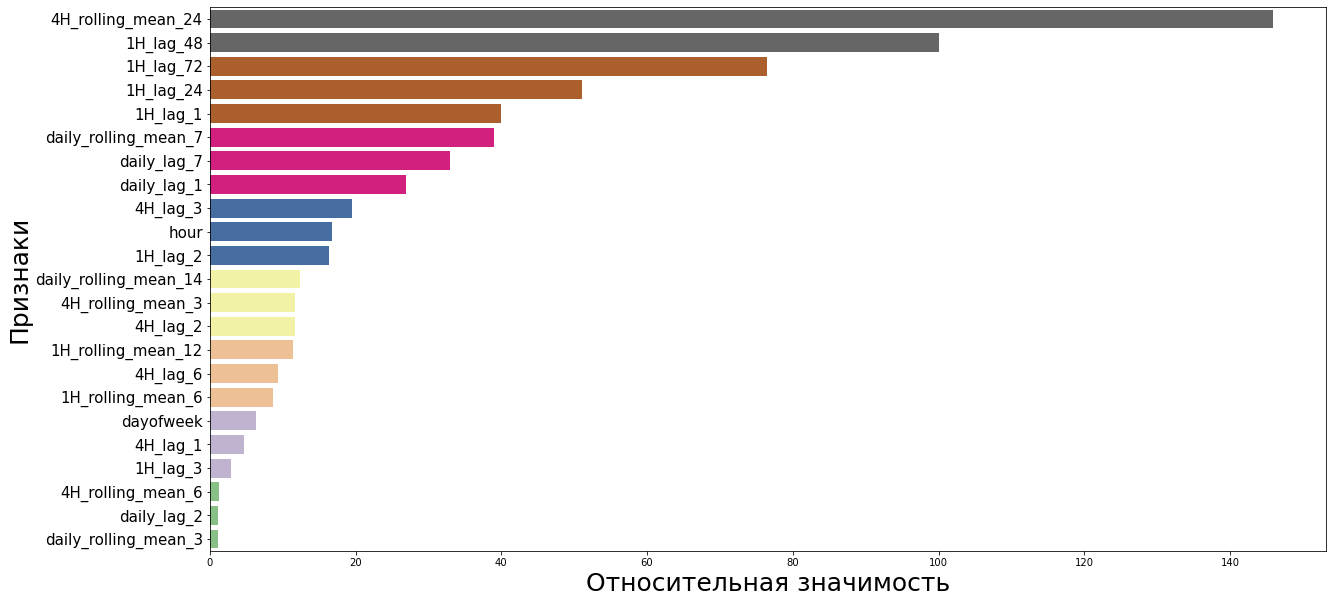

Случайный лес


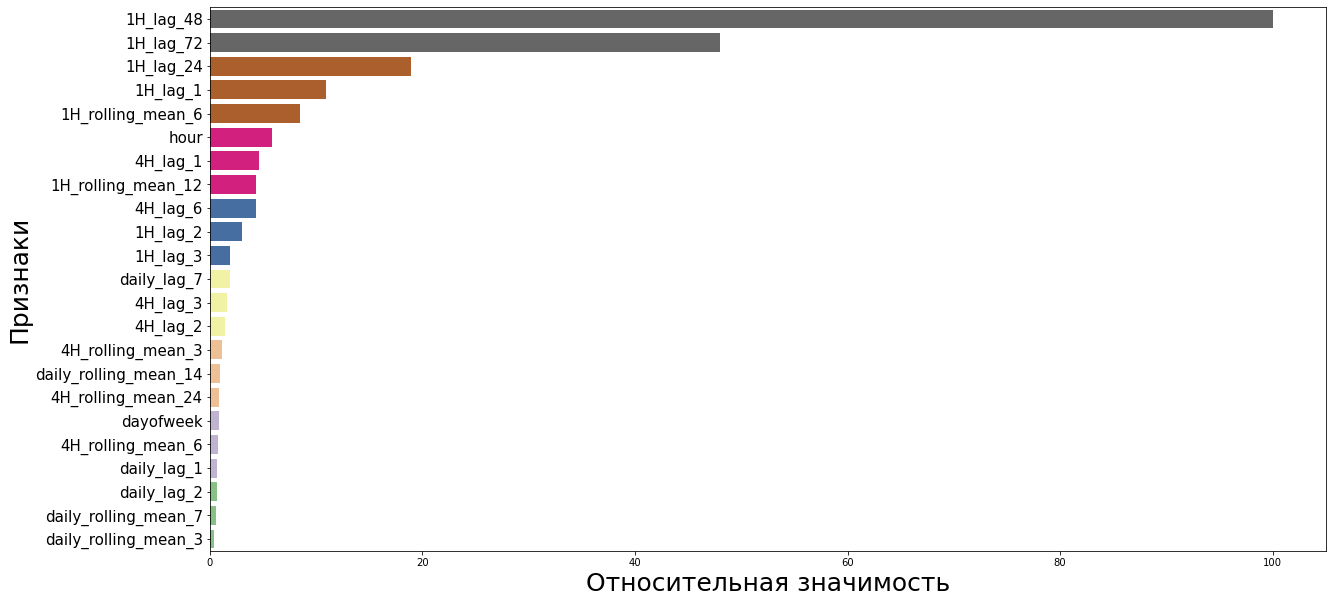

CatBoost


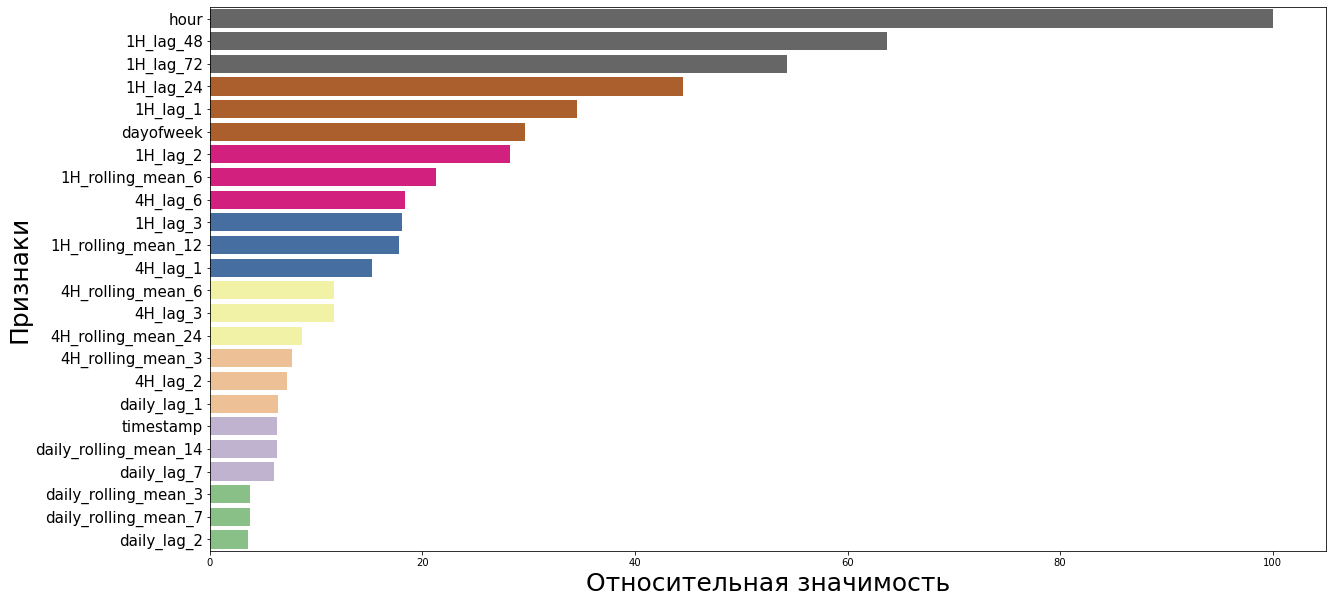

LightGBM


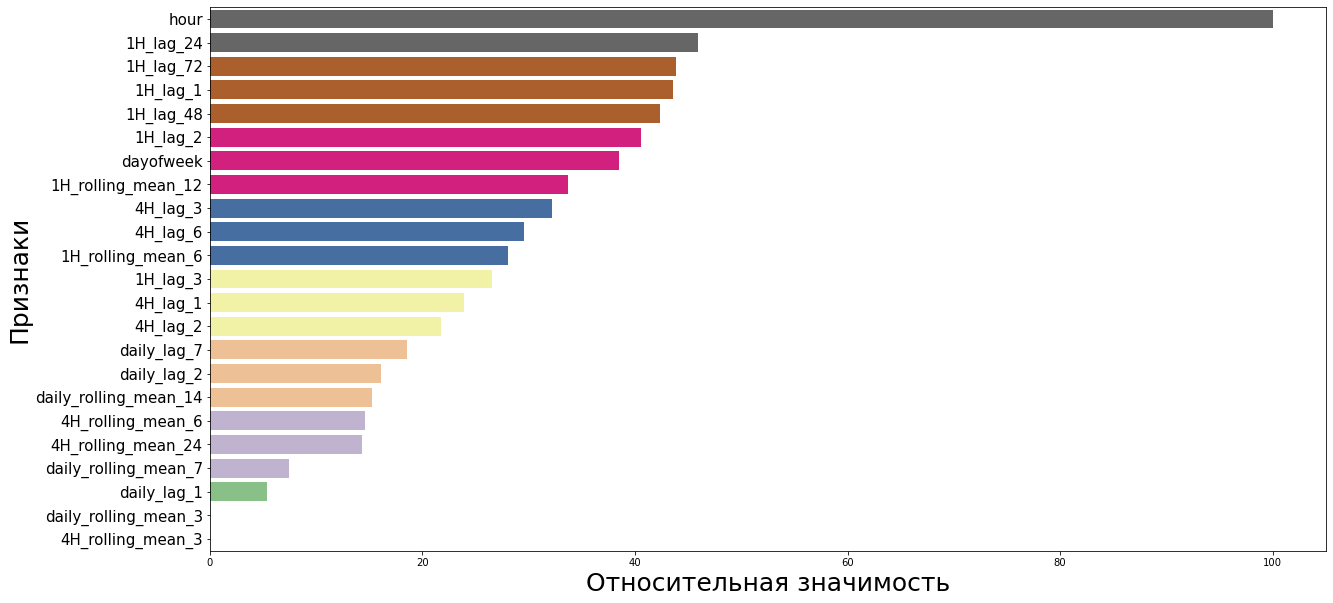

In [86]:
for key, value in feature_imp.items():
    print(key)
    print_feature_importance(value[0], value[1])

Следует отметить, что состав наиболее значимых признаков по всем моделям практически совпадает:

текущий час
значения 24, 48 и 72-часовых сдвигов
При этом в линейной регрессии наибольшей значимостью обладает скользящая средняя 4-часовых периодов, рассчитываемая по 24-периодному окну (4 дня).

Наиболее сбалансированные веса обучающих признаков в модели LightGBM.

Также следует отметить важность во многих моделях признака числа заказов неделю назад (daily_lag_7), что снова подтверждает наличие ярко выраженной недельной цикличности.

В целом следует отметить, что указанное сочетание признаков, содержащее как значения сдвигов (разных интервалов на разных масштабах), так и значения скользящих средних (по разным окнам) позволило достичь и существенно превзойти целевое значение метрики RMSE всеми рассмотренными моделями.

Оценим остатки чтобы определить, какие ситуации модель предсказывает хуже всего.

In [87]:
df_diff = Y_test.copy()

In [88]:
df_diff['pred'] = grid_search.best_estimator_.predict(X_test)

In [89]:
df_diff['diff'] = df_diff['pred'] - df_diff['num_orders']
df_diff['dayofweek'] = df_diff.index.dayofweek
df_diff['hour'] = df_diff.index.hour

In [90]:
df_diff_merged = pd.concat([df_diff[df_diff['diff']>=0]['diff'], df_diff[df_diff['diff']<0]['diff']], axis=1)
df_diff_merged.columns=['pos', 'neg']
df_diff_merged.fillna(0, inplace=True)
df_diff_merged.head(5)

pos        neg
datetime                                 
2018-08-15 00:00:00   0.000000 -26.649744
2018-08-15 01:00:00  96.424573   0.000000
2018-08-15 02:00:00  45.528228   0.000000
2018-08-15 03:00:00  68.994467   0.000000
2018-08-15 04:00:00   0.000000  -0.452955

Сформируем общую таблицу с разностью между предсказанным и фактическим значением, а также признаками положительных и отрицательных ошибок по отдельности.

In [91]:
df_diff['pos'] = df_diff_merged['pos']
df_diff['neg'] = df_diff_merged['neg']
df_diff['absv'] = np.abs(df_diff['diff'])
df_diff.head(5)

num_orders        pred       diff  dayofweek  hour  \
datetime                                                                  
2018-08-15 00:00:00         211  184.350256 -26.649744          2     0   
2018-08-15 01:00:00          98  194.424573  96.424573          2     1   
2018-08-15 02:00:00         157  202.528228  45.528228          2     2   
2018-08-15 03:00:00         102  170.994467  68.994467          2     3   
2018-08-15 04:00:00         137  136.547045  -0.452955          2     4   

                           pos        neg       absv  
datetime                                              
2018-08-15 00:00:00   0.000000 -26.649744  26.649744  
2018-08-15 01:00:00  96.424573   0.000000  96.424573  
2018-08-15 02:00:00  45.528228   0.000000  45.528228  
2018-08-15 03:00:00  68.994467   0.000000  68.994467  
2018-08-15 04:00:00   0.000000  -0.452955   0.452955

Сформируем сводную таблицу ошибок по часам.

In [92]:
df_err_hour = df_diff.pivot_table(
    index='hour', 
    values=['pos', 'neg', 'diff'], 
    aggfunc=['sum']
).reset_index()

df_err_hour.columns=['hour', 'absv', 'neg', 'pos']
df_err_hour

hour        absv         neg         pos
0      0 -313.300781 -407.850682   94.549902
1      1  109.107545 -322.035480  431.143025
2      2 -116.127272 -555.357513  439.230241
3      3  411.916395 -139.826945  551.743341
4      4 -153.308966 -518.825442  365.516476
5      5  117.281612 -147.638227  264.919838
6      6  114.372588  -87.998284  202.370872
7      7  -44.092186 -126.231687   82.139501
8      8 -334.343656 -358.269581   23.925924
9      9 -312.893538 -373.222111   60.328573
10    10 -172.433116 -280.506742  108.073625
11    11   91.692218 -150.620306  242.312525
12    12 -112.630895 -225.557941  112.927046
13    13  -77.128294 -228.433526  151.305232
14    14 -174.441199 -303.903844  129.462646
15    15  -41.706241 -279.390484  237.684243
16    16   20.164791 -267.530764  287.695555
17    17  -85.964475 -377.443809  291.479334
18    18 -175.428962 -281.966426  106.537464
19    19  131.147056 -146.731397  277.878454
20    20  -65.849325 -201.898905  136.049579
21    21  -18.827902 -214.231374  195.403472
22    22  -60.217478 -222.399932  162.182454
23    23  262.281194 -143.994372  406.275566

Наибольшее количество ошибок - в ночные часы (с 1 до 4), когда, вероятно, на предсказание оказывает большое значение восходящий тренд предыдущего дня (увеличение числа заказов с 18 до 0 часов). Т.е. модель плохо улавливает завершение восходящего вечернего тренда и его смену на ночной период с малым числом заказов.

Сформируем сводную таблицу ошибок по неделям.

In [93]:
df_err_dow = df_diff.pivot_table(
    index='dayofweek', 
    values=['pos', 'neg', 'diff'], 
    aggfunc=['sum']
).reset_index()

df_err_dow.columns=['dow', 'absv', 'neg', 'pos']
df_err_dow

dow        absv          neg          pos
0    0 -766.523637 -1271.885620   505.361983
1    1   53.728326  -608.368238   662.096564
2    2  196.885071  -930.617837  1127.502908
3    3 -452.259447 -1201.991344   749.731897
4    4 -224.847419 -1089.904071   865.056652
5    5  -51.526751  -658.630060   607.103309
6    6  243.812969  -600.468605   844.281574

Построим график ошибок по дням недели.

In [94]:
fig = go.Figure()

fig.add_trace(go.Violin(x=df_diff['dayofweek'][ df_diff['pos'] > 0 ],
                        y=df_diff['pos'][ df_diff['pos'] > 0 ],
                        legendgroup='Pos', scalegroup='Pos', name='Ошибка +',
                        line_color='green')
             )
fig.add_trace(go.Violin(x=df_diff['dayofweek'][ df_diff['neg'] < 0 ],
                        y=df_diff['neg'][ df_diff['neg'] < 0 ],
                        legendgroup='Neg', scalegroup='Neg', name='Ошибка -',
                        line_color='red')
             )

fig.update_traces(box_visible=True, meanline_visible=True)
fig.update_layout(violinmode='group')
fig.show()

На графике видно, что в понедельник (день с номером 0) наибольшее количество ошибок со знаком -, т.е. когда модель предсказывает меньшее количество заказов, чем было фактически. Вероятно это связано с тем, что за выходные (когда количество заказов меньше чем в будни) значения предыдущих периодов оказывают большее значение - фактически модель плохо улавливает смену нисходящего тренда выходных дней на восходящий тренд в будни.

In [95]:
df_diff.head(5)

num_orders        pred       diff  dayofweek  hour  \
datetime                                                                  
2018-08-15 00:00:00         211  184.350256 -26.649744          2     0   
2018-08-15 01:00:00          98  194.424573  96.424573          2     1   
2018-08-15 02:00:00         157  202.528228  45.528228          2     2   
2018-08-15 03:00:00         102  170.994467  68.994467          2     3   
2018-08-15 04:00:00         137  136.547045  -0.452955          2     4   

                           pos        neg       absv  
datetime                                              
2018-08-15 00:00:00   0.000000 -26.649744  26.649744  
2018-08-15 01:00:00  96.424573   0.000000  96.424573  
2018-08-15 02:00:00  45.528228   0.000000  45.528228  
2018-08-15 03:00:00  68.994467   0.000000  68.994467  
2018-08-15 04:00:00   0.000000  -0.452955   0.452955

Оценим симметричность остатков.

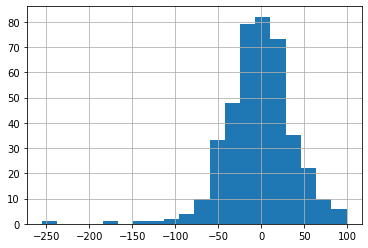

In [96]:
df_diff['diff'].hist(bins=20);

Гистограмма остатков в целом симметрична относительно 0. Но при этом есть зона "выбросов" в значениях менее 100 - видимо это соответствует плохим предсказаниям в периоды после фаз падения (когда модель предсказывает меньшее число заказов, чем фактически - например после ночных часов).

In [97]:
df_diff_plt = df_diff.query('absv < 150')

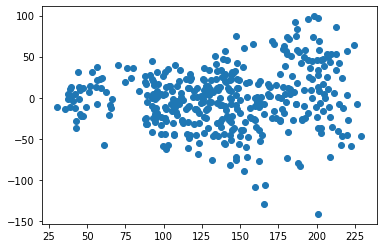

In [98]:
plt.scatter(x=df_diff_plt['pred'], y=df_diff_plt['diff']);

In [99]:
df_diff_plt = df_diff['2018-08-15':'2018-08-17'][['num_orders', 'pred']]

In [100]:
fig = go.Figure()
    
fig.add_trace(
        go.Scatter(x=df_diff_plt.index, y=df_diff_plt['num_orders'], name='факт')
    )

fig.add_trace(
        go.Scatter(x=df_diff_plt.index, y=df_diff_plt['pred'], name='предсказания')
    )

fig.update_layout(
        xaxis=dict(
            tickangle=-45,
            title='Дата',
            tickformat='%H:%M, %d-%b, %a'
        ),
        yaxis=dict(
            #range=num_range,
            title='Количество заказов',
        ),


        autosize=False,
        width=950,
        height=700
    )

fig.show()

По графику предсказаний видны "плохие" места модели: модель плохо предсказывает значение после резких колебаний/падений, например, в интервале 13-15 часов (16 августа) - в этот период падения числа заказов оказалось, видимо, больше чем обычно и модель не смогла на это правильно среагировать.

Но, наверное, для подробной интерпретации действительно необходимо привлекать бизнес - выяснять, с чем могли быть связаны аномальные зоны (например, невыход водителей/ремонт автопарка, технические сбои в системе клиент-водитель и т.д.)

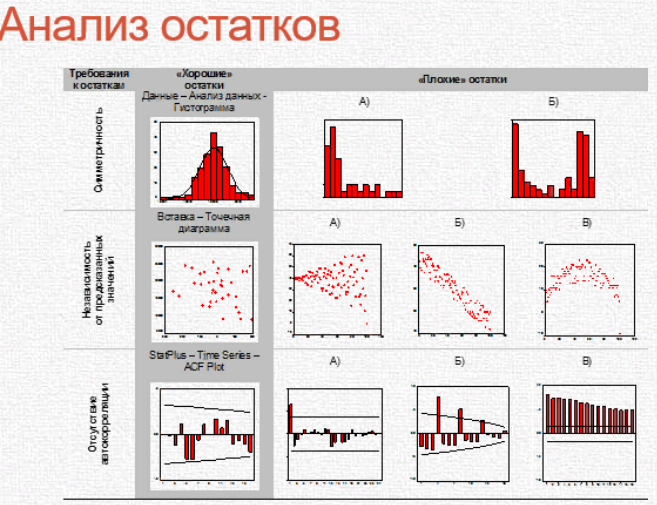

Попробуем немного улучшить качество предсказания, введя дополнительные обучающие признаки - для группы ночных часов (1 -4 часа ночи) и понедельника.

In [101]:
df_lgbm = df_train.append(df_test)

In [102]:
df_lgbm['is_night'] = np.where((df_lgbm['hour'] >= 1) & (df_lgbm['hour'] <= 4), 1, 0)
df_lgbm['is_mnd'] = np.where(df_lgbm['dayofweek'] == 0, 1, 0)
df_lgbm.drop(columns=['daily_rolling_mean_3', '4H_rolling_mean_3'], inplace=True)

In [103]:
df_lgbm.head(5)

num_orders  dayofweek  hour  1H_lag_1  1H_lag_2  \
datetime                                                               
2018-03-15 00:00:00         123          3     0      65.0      81.0   
2018-03-15 01:00:00          85          3     1     123.0      65.0   
2018-03-15 02:00:00          55          3     2      85.0     123.0   
2018-03-15 03:00:00          42          3     3      55.0      85.0   
2018-03-15 04:00:00          15          3     4      42.0      55.0   

                     1H_lag_3  1H_lag_24  1H_lag_48  1H_lag_72  \
datetime                                                         
2018-03-15 00:00:00      77.0       84.0       91.0      102.0   
2018-03-15 01:00:00      81.0       72.0       88.0      153.0   
2018-03-15 02:00:00      65.0       39.0       58.0       57.0   
2018-03-15 03:00:00     123.0       57.0       63.0       51.0   
2018-03-15 04:00:00      85.0       21.0       42.0       49.0   

                     1H_rolling_mean_6  ...  daily_rolling_mean_7  \
datetime                                ...                         
2018-03-15 00:00:00          69.500000  ...             58.755952   
2018-03-15 01:00:00          79.166667  ...             58.755952   
2018-03-15 02:00:00          85.666667  ...             58.755952   
2018-03-15 03:00:00          81.000000  ...             58.755952   
2018-03-15 04:00:00          75.166667  ...             58.755952   

                     daily_rolling_mean_14  4H_lag_1  4H_lag_2  4H_lag_3  \
datetime                                                                   
2018-03-15 00:00:00              56.491071     76.50     56.75     57.75   
2018-03-15 01:00:00              56.491071     76.50     56.75     57.75   
2018-03-15 02:00:00              56.491071     76.50     56.75     57.75   
2018-03-15 03:00:00              56.491071     76.50     56.75     57.75   
2018-03-15 04:00:00              56.491071     76.25     76.50     56.75   

                     4H_lag_6  4H_rolling_mean_6  4H_rolling_mean_24  \
datetime                                                               
2018-03-15 00:00:00     63.00          48.913119           61.135417   
2018-03-15 01:00:00     63.00          48.913119           61.135417   
2018-03-15 02:00:00     63.00          48.913119           61.135417   
2018-03-15 03:00:00     63.00          48.913119           61.135417   
2018-03-15 04:00:00     15.75          58.873810           61.718750   

                     is_night  is_mnd  
datetime                               
2018-03-15 00:00:00         0       0  
2018-03-15 01:00:00         1       0  
2018-03-15 02:00:00         1       0  
2018-03-15 03:00:00         1       0  
2018-03-15 04:00:00         1       0  

[5 rows x 24 columns]

In [104]:
features = [col for col in list(df_lgbm.columns) if col not in target]

features_category = ['dayofweek', 'hour', 'is_night', 'is_mnd']

In [105]:
for col in features_category:
    df_lgbm[col] = df_lgbm[col].astype('category')

In [106]:
df_train_lgbm = df_lgbm.loc[df_train.index]
df_test_lgbm = df_lgbm.loc[df_test.index]

In [107]:
X_train = df_train_lgbm[features]
Y_train = df_train_lgbm[target]

X_test = df_test_lgbm[features]
Y_test = df_test_lgbm[target]

In [108]:
model_lgbm = lgb.LGBMRegressor(
    random_state=random_magic,
    device="cpu"
)

params = {
    'max_depth': [5],
    'learning_rate': [0.05],
}

In [109]:
%%time
start_time = datetime.datetime.now()

grid_search = GridSearchCV(
        estimator=model_lgbm,
        param_grid=params, 
        cv=tscv, 
        scoring=scoring,
        n_jobs=-1, 
        verbose=5
    )
fitted_model = grid_search.fit(X_train, Y_train)

learning_time = (datetime.datetime.now()-start_time).seconds

print_scores(grid_search, params)

Fitting 8 folds for each of 1 candidates, totalling 8 fits
Наилучшее значение метрики RMSE: 23.109
Наилучшие параметры:
	learning_rate: 0.05
	max_depth: 5
CPU times: user 708 ms, sys: 131 ms, total: 839 ms
Wall time: 1.2 s


In [110]:
rmse_score, grid_parameters = print_scores_on_test(grid_search, params, X_test, Y_test.values.ravel())

Параметры модели:
	learning_rate: 0.05
	max_depth: 5
Значение метрики RMSE на тестовых данных: 38.58472148350383


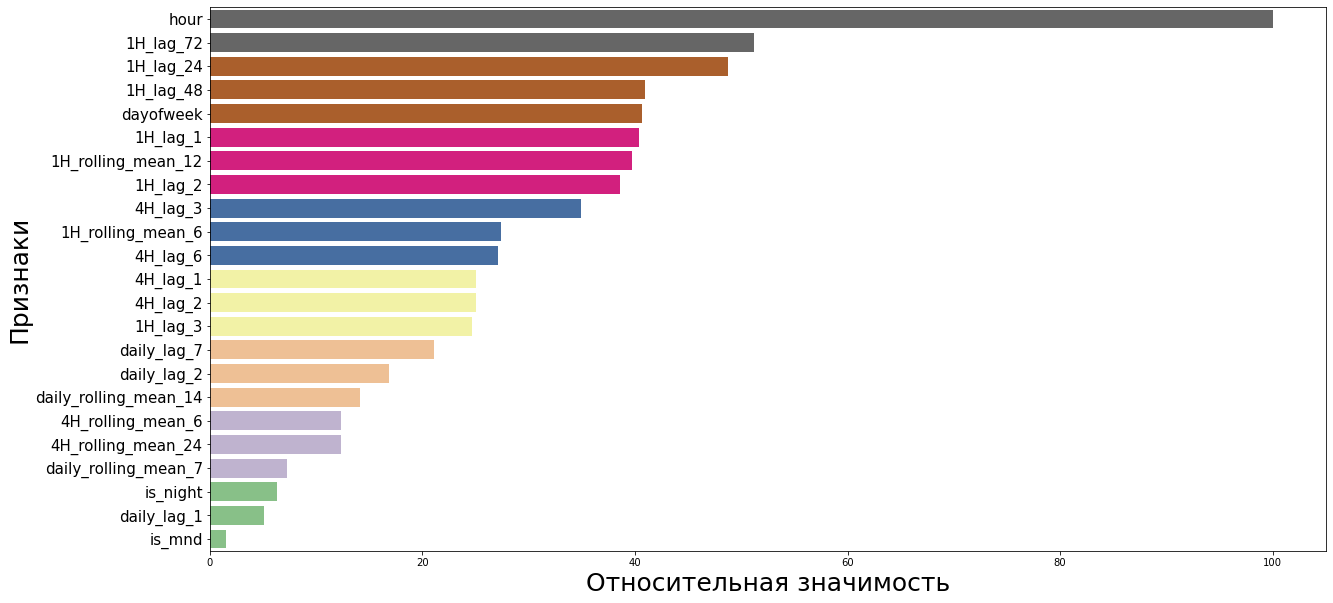

In [111]:
print_feature_importance(grid_search.best_estimator_.feature_importances_, features)

Значение метрики RMSE удалось немного улучшить. Добавленные признаки пусть и незначительно, но влияют на качество модели (их вес относительно других признаков - ненулевой).

Построим графики реальных данных и предсказаний модели в масштабе двух дней чтобы сравнить на сколько точны предсказания модели в каждый час.


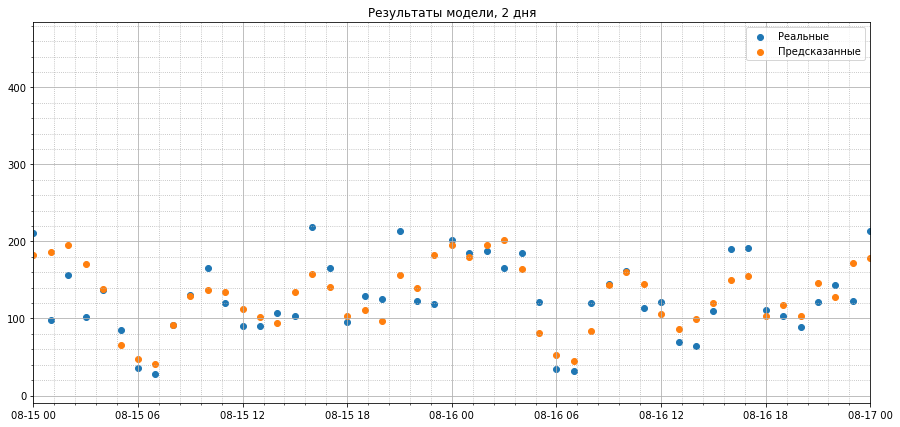

[CV 1/8] END .learning_rate=0.05, max_depth=5;, score=-17.644 total time=   0.1s
[CV 5/8] END .learning_rate=0.05, max_depth=5;, score=-23.713 total time=   0.2s
[CV 1/8] END .learning_rate=0.05, max_depth=5;, score=-17.661 total time=   0.1s
[CV 5/8] END .learning_rate=0.05, max_depth=5;, score=-23.698 total time=   0.3s
[CV 2/8] END .learning_rate=0.05, max_depth=5;, score=-22.710 total time=   0.1s
[CV 6/8] END .learning_rate=0.05, max_depth=5;, score=-21.947 total time=   0.2s
[CV 2/8] END .learning_rate=0.05, max_depth=5;, score=-22.918 total time=   0.1s
[CV 6/8] END .learning_rate=0.05, max_depth=5;, score=-21.966 total time=   0.3s
[CV 3/8] END .learning_rate=0.05, max_depth=5;, score=-21.024 total time=   0.2s
[CV 7/8] END .learning_rate=0.05, max_depth=5;, score=-27.945 total time=   0.2s
[CV 3/8] END .learning_rate=0.05, max_depth=5;, score=-20.896 total time=   0.2s
[CV 7/8] END .learning_rate=0.05, max_depth=5;, score=-28.098 total time=   0.3s
[CV 4/8] END .learning_rate=

In [112]:
plt.figure(figsize=(15, 7))
plt.scatter(x=Y_test.index, y=Y_test, 
            label='Реальные')

plt.scatter(x=Y_test.index, y=fitted_model.predict(X_test),
            label='Предсказанные')

plt.xlim(pd.Timestamp('2018-08-15'), 
         pd.Timestamp('2018-08-17'))

plt.grid(which='major')
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')

plt.legend(loc='upper right')
plt.title('Результаты модели, 2 дня');

По графику видно, что после добавления дополнительных обучающих признаков предсказания довольно близки к реальным даннымю, видны основные не "попадалки" модели -  первые ночные часы 15 августа, утро 16 августа и промежуток с 16 до 17 в оба дня. Я думаю, зная ньюансы бизнеса, можно еще улучшить качество и предсказания модели,в целом, можно сказать, что наша модель в плане предсказания достаточно хороша.

### Выводы:

В рамках исследования проведено построение моделей машинного обучения с целью предсказания количества заказов такси на следующий час на основе данных за полгода.

Исходные данные представлены в виде одной таблицы с двумя признаками:

* дата и время
* количество заказов В таблице содержится порядка 26.5 тысяч записей с данными о количестве заказов такси (в 10-минутном интервале). В таблице данные представлены за период с 01 марта 2018 года по 31 августа 2018 года (6 месяцев).

В рамках анализа проведено дополнительное ресемплирование данных - по дням и 4-часовым промежуткам - и выявление трендов и сезонности в полученных данных.

Результаты ресемплирования и анализа дневных, 4-часовых и часовых графиков позволяют выявить следующие закономерности:

* общий тренд рассматриваемых данных - восходящий
* данные обладают выраженной недельной и суточной сезонностью (поскольку данные представлены только за 6 месяцев говорить о выявлении более крупных сезонных зависимостях не представляется возможным)

Выявленные закономерности позволяют сделать предположение о возможных обучающих признаках - различных комбинациях исторических значений (предыдущих периодов со сдвигом) и скользящих средних переменных размеров окна. Эти предположения были учтены при формировании обучающих признаков для моделей машинного обучения, при генерации признаков соблюдались следующие требования:

* в каждом масштабе сохраняем ближайшие предыдущие значения и значения прошлого аналогичного периода (например, для недельного цикла это будут значения - 1, 2 дня назад и 7 дней назад (предыдущий аналог)
* скользящие средние комбинируем по окнам разной ширины (при этом для более коротких скользящих средних выбираем способ построения, учитывающий последния значения с бОльшим весом относительно более старых)

Проведено обучение 4 различных видов моделей машинного обучения:

* линейная регрессия
* случайный лес
* CatBoostRegressor
* LGBMRegressor 

Все модели улучшили значение метрики RMSE dummy-модели более чем в 1.5 раза. При этом модели градиентного бустинга показали наилучшее значение метрики ~39.3 и ~ 39.1, что на 10% лучше результатов линейной регрессии и случайного леса.
С помощью модели LightGBM получено наилучшее значение метрики RMSE. При этом время обучения LightGBM намного меньше чем у CatBoost.

В целом следует отметить, что качество линейной регрессии и случайного леса также вполне удовлетворительны - в 1.5 раза лучше dummy-модели и на 10% хуже градиентного бустинга.

Также следует отметить, что состав наиболее значимых признаков по всем моделям практически совпадает:

* текущий час
* значения 24, 48 и 72-часовых сдвигов

При этом в линейной регрессии наибольшей значимостью обладает скользящая средняя 4-часовых периодов, рассчитываемая по 24-периодному окну (4 дня).

Наиболее сбалансированные веса обучающих признаков в модели LightGBM.

Также следует отметить важность во многих моделях признака числа заказов неделю назад (daily_lag_7), что снова подтверждает наличие ярко выраженной недельной цикличности.

В целом следует отметить, что указанное сочетание признаков, содержащее как значения сдвигов (разных интервалов на разных масштабах), так и значения скользящих средних (по разным окнам) позволило достичь и существенно превзойти целевое значение метрики RMSE всеми рассмотренными моделями.

На завершающем этапе проведена оценка ошибок предсказаний модели LightGBM по дням недели и часам:

* определено, что наиболее количество ошибок - в ночные часы (с 1 до 4), когда вероятно на предсказание оказывает большое значение восходящий тренд предыдущего дня (увеличение числа заказов с 18 до 0 часов). Т.е. модель плохо улавливает завершение восходящего вечернего тренда и его смену на ночной период с малым числом заказов.
* кроме того в понедельник наибольшее количество ошибок со знаком -, т.е. когда модель предсказывает меньшее количество заказов, чем было фактически. Вероятно это связано с тем, что за выходные (когда количество заказов меньше чем в будни) значения предыдущих периодов оказывают большее значение - фактически модель плохо улавливает смену нисходящего тренда выходных дней на восходящий тренд в будни.

На основе этого сформированы два дополнительных обучающих признака и проведено повторное обучение модели LightGBM с теми же гиперпараметрами, что позволило еще немного улучшить метрику RMSE. Вместе с тем следует отметить, что подбор обучающих признаков для обучения рассматриваемой модели требует проведения возможно более подробных исследований (перебора по более широкой комбинации сдвиговых и скользящих признаков).